# Cardiac Mechanics Tutorial
### Cardiac Biomechanics Lab @ UofM
### Prof. David Nordsletten

#### @author: Javiera Jilberto Vallejos (jilberto@umich.edu)

#### This tutorial uses dolfin-x to implement the simulation of a cardiac cycle in a left ventricle. 


Importing packages

In [1]:
import time
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx import io, fem, nls

data_path = 'data/'     # path where files are

### Defining the domain
Read the mesh and boundary information (meshtags)

In [19]:
# Read mesh
with io.XDMFFile(MPI.COMM_WORLD, data_path + 'mesh.xdmf', "r") as xdmf:
    domain = xdmf.read_mesh(name='Grid')

# Read meshtags (boundary information)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)
with io.XDMFFile(MPI.COMM_WORLD, data_path + 'mt.xdmf', "r") as xdmf:
    meshtags = xdmf.read_meshtags(domain, name="Grid")

The loaded meshtags are shown in the image below and will be necessary to assign boundary conditions to specific surfaces of the mesh. 

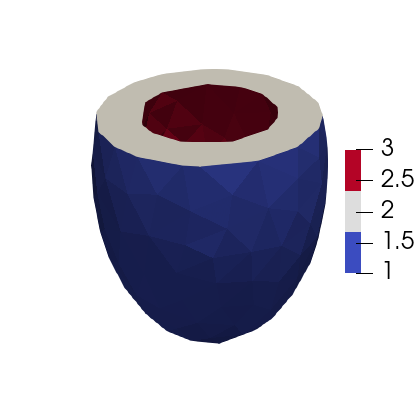

### Defining FE spaces and functions of interest
Define finite element function spaces. In this tutorial, we use a nearly-incompressible simulation, which means we solve for both the displacement and pressure. To do that we first define element types for each field and then a function space is defined that combines both this variables. 

In [3]:
order_u = 1      # polynomial degree for displacement
order_p = 1      # polynomial degree for pressure
Ve = ufl.VectorElement("Lagrange", domain.ufl_cell(), order_u)   # element for displacement: linear continuous lagrange 
Pe = ufl.FiniteElement("Lagrange", domain.ufl_cell(), order_p)   # element for displacement: linear continuous lagrange 

state_space = fem.FunctionSpace(domain, Ve * Pe)

Now we can define the functions and test functions that are going to be used to define and solve the cardiac mechanics variational problem. Note that we first define a global function/test function (containing displacement and pressure) from the space that we defined before and then we split that space into the displacement and pressure variables. 

In [4]:
# Define functions and test functions
state = fem.Function(state_space)
test_state = ufl.TestFunction(state_space)

u, p = ufl.split(state)       # Splitting the state variable
v, q = ufl.split(test_state)  # Splitting the test variable

### Defining microstructure (fibers)
The fibers for these geometry are provided in the data directory. To use them, we need to define a function space for them and then create functions and assign the values from the data.

In [5]:
# Defining fiber function space
V_f = fem.VectorFunctionSpace(domain, ('CG', 1))       # space for fibers - continuous linear space

# Defining functions
f0 = fem.Function(V_f)    # In this tutorial fibers are defined in a linear topology
s0 = fem.Function(V_f)
n0 = fem.Function(V_f)

# Reading data
f0_array = np.loadtxt(data_path + 'fiber.txt')
s0_array = np.loadtxt(data_path + 'sheet.txt')
n0_array = np.loadtxt(data_path + 'sheetnormal.txt')

# Assigning values
f0.vector.array = f0_array.flatten()
s0.vector.array = s0_array.flatten()
n0.vector.array = n0_array.flatten()

Fenics-x calculates quantities and expressions at the quadrature points by interpolating nodal values. One issue that arises with very coarse meshes (as the one used in this tutorial) is that the unitary vectors lose the unitary property when they are interpolated, which causes some issues. For finer meshes, this is not a big problem as the variation between the nodes of an element is small. To avoid issues in this tutorial we precompute the outer product in the fiber direction.

In [6]:
# Define tensor space
T_f = fem.TensorFunctionSpace(domain, ('CG', 1))       # space for outer product - continuous linear space

# pre compute outer product using nodal values
outer_ff = np.zeros([*f0_array.shape, 3])
for i in range(len(f0_array)):
    outer_ff[i] = np.outer(f0_array[i], f0_array[i])
    
# Assign values to a fenics-x function
ff = fem.Function(T_f)
ff.vector.array = outer_ff.flatten()

### Defining the constitutive relationship
Once that all the functions needed are defined, we can define our constitutive relationship. We first define all the continuum mechanics quantities needed.

In [7]:
# Kinematics
dim = len(u)
I = ufl.variable(ufl.Identity(dim))
F = ufl.variable(I + ufl.grad(u))         # Deformation gradient
C = ufl.variable(F.T*F)                   # Right Green-Cauchy tensor

# Invariants
J = ufl.variable(ufl.det(F))
Ic = ufl.variable(ufl.tr(C))
Ic_bar = ufl.variable(J**(-2./3.) * Ic)
I4f = ufl.inner(C, ff)

With this quantities, we define the strain energy density function defining the consitutive relationship. In this tutorial, we will use a modified HO material that only contains the first two terms (isotropic and fiber direction), and that we use an isochoric invariant for the first term. 

In [8]:
# Define HO material law
a = fem.Constant(domain, PETSc.ScalarType(0.4))
b = fem.Constant(domain, PETSc.ScalarType(3.2))
a_f = fem.Constant(domain, PETSc.ScalarType(1.0))
b_f = fem.Constant(domain, PETSc.ScalarType(15.))
Psi_dev = a/(2.*b)*(ufl.exp(b*(Ic_bar-3.)) - 1.) \
    + a_f/(2.*b_f)*(ufl.exp(b_f*(I4f-1.)**2.) - 1.)

We also need to define the volumetric strain energy density function. Here, we use a nearly incompressible material law.

In [9]:
k = fem.Constant(domain, PETSc.ScalarType(1e2))
Psi_vol = p * (J - 1) - p**2 / (2*k)

The first Piola-Kirchhoff stress can be easily computed by differentiating the strain energy density function.

In [10]:
P_dev = ufl.diff(Psi_dev,F)    # Deviatoric contribution
P_vol = ufl.diff(Psi_vol,F)    # Volumetric contribution

For the activation of the myocardium, we use an active stress approach with a length-dependent term $\phi$.

In [11]:
# Define active stress
f = F*f0       # Deformed fiber direction
phi = ufl.tanh(3.75*(ufl.sqrt(I4f)-0.8))    # length dependent activation
lv_activation = fem.Constant(domain, PETSc.ScalarType(0.))   # value of activation
P_act = lv_activation * phi * ufl.outer(f,f0)

### Defining boundary conditions
For this simple problem, we consider a dirichlet condition (in all directions) in the LV base plus the pressure load in the inner surface of the LV. Note that, since we are using a mixed space to solve for, we need to make sure the BC is applied to the correct space. 

In [12]:
# Boundary conditions
# Fixed base
V, _ = state_space.sub(0).collapse()    # Obtaining the function space of the displacement
dofs = fem.locate_dofs_topological((state_space.sub(0), V), 2, meshtags.find(2))   # Finding the degrees of freedom to be constrained
u_fixed = fem.Function(V)    # Function containing dirichlet condition valeus
u_fixed.x.set(0.0)
bcs = [fem.dirichletbc(u_fixed, dofs, state_space.sub(0))] 

# Endocardial pressure
normal_0 = ufl.FacetNormal(domain)
lv_pressure = fem.Constant(domain, PETSc.ScalarType(0.))   # This contains the lv pressure value. Initialize with 0.
T = -lv_pressure * J * ufl.inv(F).T * normal_0

### Defining virtual work principle

In [13]:
# Define integration domains
ds = ufl.Measure('ds', domain=domain, subdomain_data=meshtags)
dx = ufl.Measure("dx", domain=domain, metadata={'quadrature_degree': 4})

# Virtual work
deltaW_uu = ufl.inner(ufl.grad(v), P_dev)*dx +  ufl.inner(ufl.grad(v), P_act)*dx - ufl.inner(v, T)*ds(3)
deltaW_up = ufl.inner(ufl.grad(v), P_vol)*dx
deltaW_pu = q * (J - 1.) * dx
deltaW_pp = - 1/k * p * q * dx
deltaW = deltaW_uu + deltaW_up + deltaW_pu + deltaW_pp

### Setting up the solver

In [14]:
problem = fem.petsc.NonlinearProblem(deltaW, state, bcs)   # problem to be solve
solver = nls.petsc.NewtonSolver(domain.comm, problem)

# Solver options
solver.atol = 1e-8
solver.rtol = 1e-8
solver.error_on_nonconvergence = False

## Cardiac Simulation
We provide files defining pressure and an activation curve in time defining a cardiac cycle. These files have two columns each. The first one is time and the second the activation values. For easiness of implementation we use the `interp1d` function from `scipy` to define functions that we can evaluate at any time `t`. 

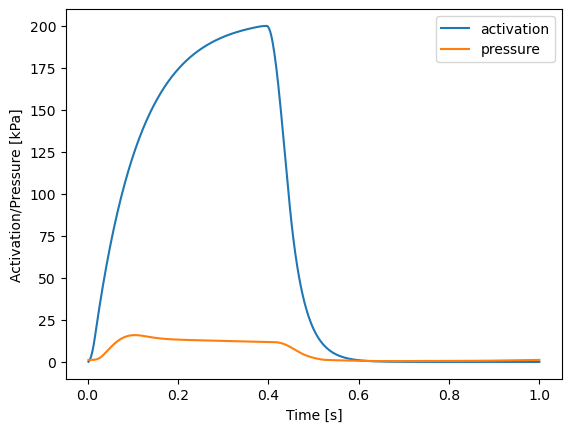

In [15]:
# Read data for activation and pressure
activation = np.loadtxt(data_path + 'activation.txt')
pressure = np.loadtxt(data_path + 'pressure.txt')

# Defining functions
from scipy.interpolate import interp1d
func_act = interp1d(activation[:,0], activation[:,1])
func_pres = interp1d(pressure[:,0], pressure[:,1])

# Defining cycle times
nsteps = 501
times = np.linspace(0, 1, nsteps)[1:]    

import matplotlib.pyplot as plt
plt.figure()
plt.plot(times, func_act(times), label='activation')
plt.plot(times, func_pres(times), label='pressure')
plt.xlabel('Time [s]')
plt.ylabel('Activation/Pressure [kPa]')
plt.legend()

A cardiac cycle simulation contains two steps, an inflation problem to reach the initial pressure of the cycle and the cycle itself.

### Inflation problem

In [16]:
# Initializing files to save results. Results are saved in the inflation.xdmf file that can be view in paraview.
# If an error appears saying that the HD5F file is already open, make sure to delete any old .xdmf and .h5 files from previous runs.
file = io.XDMFFile(MPI.COMM_WORLD, 'inflation.xdmf', 'w')   
file.write_mesh(domain)

# Incremmentally load the lv using N timesteps
nsteps = 21
pres_values = np.linspace(0, func_pres(0), nsteps+1)[1:]
for i in range(len(pres_values)):
    # Assign pressure value
    lv_pressure.value = pres_values[i]
    
    # Solve
    num_its, converged = solver.solve(state)
    if not converged:   # Check convergence and close file if failure
        file.close()
        assert converged
        
    # Save output
    u, p = state.split()
    file.write_function(u, i)
    
    # Print status
    print(f"Time step {i}, Number of iterations {num_its}, pressure {lv_pressure.value}")
file.close()

# Save inflated state in case we need to restart the next step
inf_state = fem.Function(state_space)
inf_state.vector.array = np.copy(state.vector.array)

Time step 0, Number of iterations 4, pressure 0.05728465007595871
Time step 1, Number of iterations 4, pressure 0.11456930015191742
Time step 2, Number of iterations 4, pressure 0.17185395022787614
Time step 3, Number of iterations 4, pressure 0.22913860030383484
Time step 4, Number of iterations 4, pressure 0.28642325037979355
Time step 5, Number of iterations 4, pressure 0.3437079004557523
Time step 6, Number of iterations 4, pressure 0.40099255053171096
Time step 7, Number of iterations 4, pressure 0.4582772006076697
Time step 8, Number of iterations 4, pressure 0.5155618506836284
Time step 9, Number of iterations 4, pressure 0.5728465007595871
Time step 10, Number of iterations 4, pressure 0.6301311508355458
Time step 11, Number of iterations 4, pressure 0.6874158009115046
Time step 12, Number of iterations 4, pressure 0.7447004509874633
Time step 13, Number of iterations 4, pressure 0.8019851010634219
Time step 14, Number of iterations 4, pressure 0.8592697511393806
Time step 15, 

### Cardiac Cycle
**WARNING**: This step takes around 5 min, more or less depending on your computer. The output files are provided in the results folder.

In [17]:
# Uncomment if you want to restart this step.
# state.vector.array = np.copy(inf_state.vector.array)

# Initializing file to save results
file = io.XDMFFile(MPI.COMM_WORLD, 'cycle.xdmf', 'w') 
file.write_mesh(domain)

start = time.time()  # For timing the simulation
nsteps = 501
times = np.linspace(0, 1, nsteps)[1:]    # We already solved the first step
for i, t in enumerate(times):
    # Set pressure/activation values
    lv_pressure.value = func_pres(t)
    lv_activation.value = func_act(t)

    # Solve
    num_its, converged = solver.solve(state)

    if not converged:  # Check convergence and close file if failure
        file.close()
        assert converged

    # Save output
    u, p = state.split()
    file.write_function(u, i)

    print(f"Time step {i}, Number of iterations {num_its}, pressure {lv_pressure.value}, activation {lv_activation.value}")
file.close()

end = time.time()

print(f"Simulation time {end-start} s")

Time step 0, Number of iterations 3, pressure 1.203658798217899, activation 0.1227461346798
Time step 1, Number of iterations 4, pressure 1.2040335220676555, activation 0.735042900635
Time step 2, Number of iterations 5, pressure 1.2046121076707685, activation 1.8319215265253999
Time step 3, Number of iterations 5, pressure 1.206595431757427, activation 3.4049657113864
Time step 4, Number of iterations 5, pressure 1.2143398963171526, activation 5.4424260063578
Time step 5, Number of iterations 5, pressure 1.2365235157571695, activation 7.9293653147742
Time step 6, Number of iterations 4, pressure 1.2729798772168495, activation 10.8478405118564
Time step 7, Number of iterations 4, pressure 1.33251562948175, activation 14.177117107749801
Time step 8, Number of iterations 4, pressure 1.4224186816991287, activation 17.856924623874207
Time step 9, Number of iterations 4, pressure 1.5504583812782606, activation 21.538217550852202
Time step 10, Number of iterations 3, pressure 1.7241880112099

In [18]:
# Cleaning up
f0.vector.destroy()
s0.vector.destroy()
n0.vector.destroy()
ff.vector.destroy()
u.vector.destroy()